# `CLOUD.jl` - 2D linear advection example

In [62]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures

## Define the physical problem

In [63]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)))
initial_data = InitialDataSine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters (energy-conservative scheme)

In [64]:
M = 4
p = 4
p_map = 4
form = WeakConservationForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(0.0))
strategy = ReferenceOperator()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.25*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*10));

## Set up a `NodalTensor` scheme on quadrilaterals of degree `p` with `M` edges in each direction

In [65]:
reference_approximation = ReferenceApproximation(
    NodalTensor(p), Quad(), mapping_degree=p_map)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.2)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), strategy,
     "results/advection_2d/", overwrite=true, clear=true);

## Run the solver

In [66]:
ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy);

CLOUD_reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, (0.0,T), write_interval))
CLOUD_print_timer()

 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            650ms /  82.1%            425MiB /  97.2%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual         16.5k    495ms   92.8%  30.0μs    394MiB   95.3%  24.4KiB
   apply operators      16.5k    227ms   42.6%  13.8μs    240MiB   58.1%  14.9KiB
     volume terms       16.5k    121ms   22.6%  7.31μs    175MiB   42.2%  10.8KiB
     mass matrix solve  16.5k   19.6ms    3.7%  1.18μs   8.07MiB    2.0%     512B
     facet terms        16.5k   14.8ms    2.8%   896ns   22.9MiB    5.6%  1.42KiB
     mul test function  16.5k   7.78ms    1.5%   471ns   8.83MiB    2.1%     560B
   gather ext s

## Calculate the integral L<sup>2</sup> error norm

In [67]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)

L2 error:
0.07575407088358227


## Analyze conservation and energy dissipation

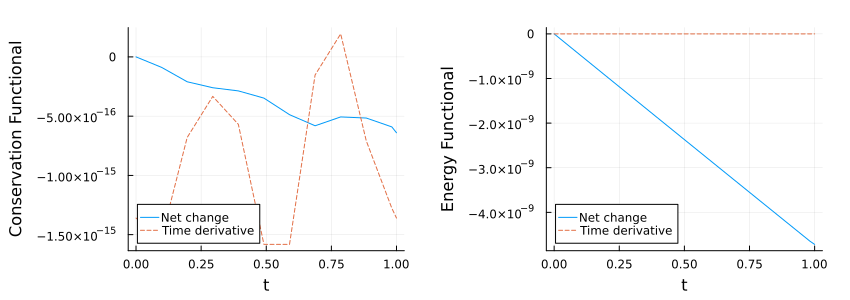

In [68]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), ylabel="Conservation Functional");
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), ylabel="Energy Functional");
plot(p1,p2, size=(850,300),margin=5mm)

## Postprocess for VTK visualization

In [69]:
postprocess_vtk(spatial_discretization, string(results_path,"solution.vtu"), last(sol.u));